<a href="https://colab.research.google.com/github/merucode/RL/blob/12-Colab-Study-Basic-Format/01-DQN-Basic_format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1. Model and Training

In [11]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32


In [13]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

In [14]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else :
            return out.argmax().item()

In [15]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [151]:
def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0
    score_recoder = []
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, truncated = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break

        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            score_recoder.append(score/print_interval)
            score = 0.0
    env.close()
    torch.save(q.state_dict(), 'model_weights.pth')

    return score_recoder

In [152]:
score_recoder = main()

n_episode :20, score : 145.5, n_buffer : 2910, eps : 7.9%
n_episode :40, score : 143.2, n_buffer : 5775, eps : 7.8%
n_episode :60, score : 136.3, n_buffer : 8502, eps : 7.7%
n_episode :80, score : 132.1, n_buffer : 11144, eps : 7.6%
n_episode :100, score : 116.8, n_buffer : 13480, eps : 7.5%
n_episode :120, score : 120.2, n_buffer : 15884, eps : 7.4%
n_episode :140, score : 97.8, n_buffer : 17841, eps : 7.3%
n_episode :160, score : 116.5, n_buffer : 20172, eps : 7.2%
n_episode :180, score : 137.1, n_buffer : 22914, eps : 7.1%
n_episode :200, score : 163.3, n_buffer : 26180, eps : 7.0%
n_episode :220, score : 155.2, n_buffer : 29285, eps : 6.9%
n_episode :240, score : 205.7, n_buffer : 33399, eps : 6.8%
n_episode :260, score : 248.0, n_buffer : 38359, eps : 6.7%
n_episode :280, score : 202.7, n_buffer : 42412, eps : 6.6%
n_episode :300, score : 265.4, n_buffer : 47721, eps : 6.5%
n_episode :320, score : 318.3, n_buffer : 50000, eps : 6.4%
n_episode :340, score : 384.1, n_buffer : 50000,

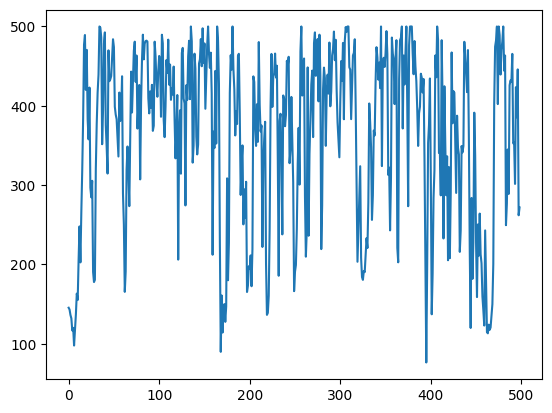

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(score_recoder)
plt.show()

# STEP 2. TEST

In [156]:
env = gym.make('CartPole-v1')

video_every=1

# define a trigger function, return True to start recording a new video:
episode_trigger=lambda episode_id: ((episode_id)%video_every==0)

# decorate env with a video recorder:
env = gym.wrappers.RecordVideo(env, "./video", episode_trigger=episode_trigger, video_length=100000)

def model_render():


    s = env.reset()
    done = False
    score = 0

    q = Qnet()
    q.load_state_dict(torch.load('model_weights.pth'))
    q.eval()

    while not done:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon=0)
        s_prime, r, done, _ = env.step(a)
        done_mask = 0.0 if done else 1.0
        s = s_prime
        score += r

    print(score)
    env.close()

In [175]:
model_render()

  logger.deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



154.0


In [174]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./video/rl-video-episode-14.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [131]:
"""
# create an environment
env = gym.make("CartPole-v1")

video_every=100

# define a trigger function, return True to start recording a new video:
episode_trigger=lambda episode_id: ((episode_id+1)%video_every==0)

# decorate env with a video recorder:
env = gym.wrappers.RecordVideo(env, "./video", episode_trigger=episode_trigger, video_length=100000)
done = True



#
for step in range(100):
    if done:
        env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    print((env.episode_id+1)%video_every)
env.close()


#
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./video/rl-video-episode-0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
"""

SyntaxError: ignored